# Personal Project
## Candidate ID: 215850

## Importing and Pre-processing

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive
import sys
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import print_function
import json
from google.colab import files

In [ ]:
# Allow access to Google Drive, as this is where the CSV file is with the dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the Pandas dataframe up and display the first 255 entries
path="/content/drive/MyDrive/Colab Notebooks/Personal Project/prices.csv"
df=pd.read_csv(path)
df.head(255)

,date,symbol,open,close,low,high,volume
0,05/01/2016 00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600
1,06/01/2016 00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400
2,07/01/2016 00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500
3,08/01/2016 00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300
4,11/01/2016 00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600
...,...,...,...,...,...,...,...
250,30/12/2016 00:00,WLTW,122.589996,122.279999,121.389999,123.559998,466400
251,04/01/2010,A,31.389999,31.300001,31.130000,31.630001,3815500
252,04/01/2010,AAL,4.840000,4.770000,4.660000,4.940000,9837300
253,04/01/2010,AAP,40.700001,40.380001,40.360001,41.040001,1701700


In [ ]:
# Remove the WLTW data
df = df.iloc[251:]
df.head(25)

# Remove CHTR data as volume is 0
df.drop(df[df['symbol'] == 'CHTR'].index, inplace = True)

In [ ]:
# Change the datatype of volume to float, to match the other columns
df['volume'] = df['volume'].astype(float)

*The above step was implemented in attempt to fix an issue with the wrong data type when fitting model, which was not the solution. But we decided to keep this step, as could prove useful in the future to have all of the same data type.*

In [ ]:
# Dataframe with just Day 1, which provides us with a list of all the stocks included in the dataset
day1 = df.loc[df['date'] == '04/01/2010']
day1

,date,symbol,open,close,low,high,volume
251,04/01/2010,A,31.389999,31.300001,31.130000,31.630001,3815500.0
252,04/01/2010,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0
253,04/01/2010,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0
254,04/01/2010,AAPL,213.429998,214.009998,212.380001,214.499996,123432400.0
255,04/01/2010,ABC,26.290001,26.629999,26.139999,26.690001,2455900.0
...,...,...,...,...,...,...,...
712,04/01/2010,XRX,8.540000,8.630000,8.470000,8.760000,13472700.0
713,04/01/2010,YHOO,16.940001,17.100000,16.879999,17.200001,16587400.0
714,04/01/2010,YUM,35.120000,35.090001,35.050000,35.280001,2962300.0
715,04/01/2010,ZBH,59.310001,60.020000,59.310001,60.139999,782400.0


## Elbow and Silhouette Methods

Running the Elbow and Silhouette method on just one day of the dataset, to see if they provide similar results. This will help us determine which may be best for use on time-series data. 

In [ ]:
# Dataframe sorted in alphabetical
sorted = df.copy(deep=True)

In [ ]:
sorted['date'] = pd.to_datetime(sorted['date'])
sorted = sorted.sort_values(['symbol', 'date'])
sorted.head(75)

# Now we have the data sorted alpabetically in date order (so each symbol's data in date order together)

<ipython-input-8-7b3f7858c364>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sorted['date'] = pd.to_datetime(sorted['date'])


,date,symbol,open,close,low,high,volume
9142,2010-01-02,A,28.159999,29.130001,28.130001,29.320000,5585400.0
18034,2010-01-03,A,31.429999,32.089999,31.429999,32.129999,4723500.0
28798,2010-01-04,A,34.540000,34.550000,34.250000,34.870001,3105000.0
48009,2010-01-06,A,32.089999,31.480001,31.420000,32.370000,3883000.0
58327,2010-01-07,A,28.500001,28.280001,27.440000,28.610001,6993400.0
...,...,...,...,...,...,...,...
33478,2010-04-16,A,35.540000,35.270001,35.069999,35.900001,8066100.0
33946,2010-04-19,A,35.340001,35.160001,34.650000,35.439999,4006300.0
34414,2010-04-20,A,35.380001,36.289999,35.380001,36.469999,6989800.0
34882,2010-04-21,A,36.179999,36.130000,35.790000,36.390000,3142400.0


In [ ]:
# Set the data variable to hold just the columns we are interested in using
data = day1[['open', 'close', 'low', 'high', 'volume']]

## K-Elbow Visualizer

In [ ]:
error = {}    # Variable to hold the error values for each number of clusters - which will then be plotted on a graph for visual inspection
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)    # Fit the data
  data['clusters'] = kmeans.labels_   # Add the labels to each of the stocks in the dataset
  error[k] = kmeans.inertia_    # Calculate the error and add it to the variable

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-0cae90ed2123>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clusters'] = kmeans.labels_   # Add the labels to each of the stocks in the dataset
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-0cae90ed2123>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

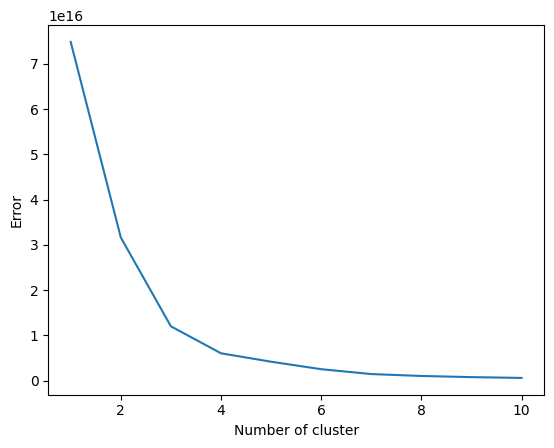

In [ ]:
# Plot the graph
plt.figure()    
plt.plot(list(error.keys()), list(error.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Error")
plt.show()

## Silhouette Analysis

In [ ]:
# Similar to the elbow method, but with an added step of calculating the sihoutte score
values = {}
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(data)
    label = kmeans.labels_
    sil_coeff = silhouette_score(data, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    values[n_cluster] = sil_coeff

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

For n_clusters=2, The Silhouette Coefficient is 0.9076574849431376
For n_clusters=3, The Silhouette Coefficient is 0.8615329810472335
For n_clusters=4, The Silhouette Coefficient is 0.7444326873601691
For n_clusters=5, The Silhouette Coefficient is 0.7319450561103686
For n_clusters=6, The Silhouette Coefficient is 0.7352758211437161
For n_clusters=7, The Silhouette Coefficient is 0.6303849727350981


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, The Silhouette Coefficient is 0.5887887803502007
For n_clusters=9, The Silhouette Coefficient is 0.5874194703933465
For n_clusters=10, The Silhouette Coefficient is 0.578400387202769


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print(values)

{2: 0.9076574849431376, 3: 0.8615329810472335, 4: 0.7444326873601691, 5: 0.7319450561103686, 6: 0.7352758211437161, 7: 0.6303849727350981, 8: 0.5887887803502007, 9: 0.5874194703933465, 10: 0.578400387202769}


*A higher Silhouette Coefficient indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. So the best value is the one which makes a large drop in value, with the remaining values being quite similar to each other and not much change.*

## Testing

Does the test produce values we would expect? If not, why? 

In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=1000, init='k-means++', n_init='auto').fit(data)
day1['clusters'] = kmeans.labels_
iterations = kmeans.n_iter_

<ipython-input-29-e79471544dd8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day1['clusters'] = kmeans.labels_


In [ ]:
print(day1)

           date symbol        open       close         low        high  \
251  04/01/2010      A   31.389999   31.300001   31.130000   31.630001   
252  04/01/2010    AAL    4.840000    4.770000    4.660000    4.940000   
253  04/01/2010    AAP   40.700001   40.380001   40.360001   41.040001   
254  04/01/2010   AAPL  213.429998  214.009998  212.380001  214.499996   
255  04/01/2010    ABC   26.290001   26.629999   26.139999   26.690001   
..          ...    ...         ...         ...         ...         ...   
712  04/01/2010    XRX    8.540000    8.630000    8.470000    8.760000   
713  04/01/2010   YHOO   16.940001   17.100000   16.879999   17.200001   
714  04/01/2010    YUM   35.120000   35.090001   35.050000   35.280001   
715  04/01/2010    ZBH   59.310001   60.020000   59.310001   60.139999   
716  04/01/2010   ZION   12.940000   13.330000   12.880000   13.370000   

          volume  clusters  
251    3815500.0         0  
252    9837300.0         3  
253    1701700.0        

In [ ]:
# Get ID's for each company based on symbol

# Apple and Microsoft are similar in the products and markets they share (which is not something the provided dataset hold any insights on,
# so we would be suprised to see any similarity in patter caused by these factors)
apple = day1.loc[day1['symbol'] == 'AAPL']
print("Apple: ", apple['clusters'])
microsoft = day1.loc[day1['symbol'] == 'MSFT']
print("Microsoft: ", microsoft['clusters'])

# Amazon and Google are similar in market capitalization (which is a feature the dataset may provide similarities in)
amazon = day1.loc[day1['symbol'] == 'AMZN']
print("Amazon: ", amazon['clusters'])
google = day1.loc[day1['symbol'] == 'GOOGL']
print("Google: ", google['clusters'])

# All four of the companies are in the same sector (tech) and are well established, so make for good comparison 

Apple:  254    1
Name: clusters, dtype: int32
Microsoft:  544    3
Name: clusters, dtype: int32
Amazon:  284    0
Name: clusters, dtype: int32
Google:  440    0
Name: clusters, dtype: int32


# Time-series Clustering 

From the test above, we found there not to be a large difference in evaluation between the elbow and silhouette methods. Therefore, we will implement the elbow method for the time-series model. 

In [ ]:
%pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 9.7 MB/s eta 0:00:00


In [ ]:
# Import required packages
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.metrics import dtw

In [ ]:
# Create a new dictionary, using the original dataset, but looping through the list of each of the companies from one day
newData = {}
for row in day1.itertuples():
  newData[row[2]] = df.loc[df['symbol'] == row[2]]

In [ ]:
# Check the dataset holds all the information required for one of the stocks 
print(len(newData))
print(newData['MSFT'])

466
              date symbol       open      close        low       high  \
544     04/01/2010   MSFT  30.620001  30.950001  30.590000  31.100000   
1012    05/01/2010   MSFT  30.850000  30.959999  30.639999  31.100000   
1480    06/01/2010   MSFT  30.879999  30.770000  30.520000  31.080000   
1948    07/01/2010   MSFT  30.629999  30.450001  30.190001  30.700001   
2416    08/01/2010   MSFT  30.280001  30.660000  30.240000  30.879999   
...            ...    ...        ...        ...        ...        ...   
849076  23/12/2016   MSFT  63.450001  63.240002  62.799999  63.540001   
849576  27/12/2016   MSFT  63.209999  63.279999  63.209999  64.070000   
850076  28/12/2016   MSFT  63.400002  62.990002  62.830002  63.400002   
850576  29/12/2016   MSFT  62.860001  62.900002  62.730000  63.200001   
851076  30/12/2016   MSFT  62.959999  62.139999  62.029999  62.990002   

            volume  
544     38409100.0  
1012    49749600.0  
1480    58182400.0  
1948    50559700.0  
2416    511974

In [ ]:
# Function to pre-process the data (which is passed to the function in the form of a dictionary)
def preProcess(toProcess):
  tempArray = np.dstack(toProcess.values())   # Convert the dictionary into a numpy 3d array
  tempArray = np.moveaxis(tempArray, 2, 0)    # Change the axis of the array, so it is in the correct format for tslearn
  tempArray = np.delete(tempArray, (0, 1), 2)   # Delete the date and symbol columns as these are not parameters used for clustering
  tempArray = TimeSeriesScalerMinMax().fit_transform(tempArray)   # Scale the values of the features (normalise?)
  return tempArray;

In [ ]:
# preprocess the dataset we created previously
x_scaled = preProcess(newData)

<ipython-input-33-7d5b2e3406be>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tempArray = np.dstack(toProcess.values())   # Convert the dictionary into a numpy 3d array


In [ ]:
# Elbow Method
distance = {}
for i in range(1, 31):
  kmeansTS = TimeSeriesKMeans(n_clusters=i, max_iter=1000)
  kmeansTS.fit(x_scaled)
  distance[i] = kmeansTS.inertia_

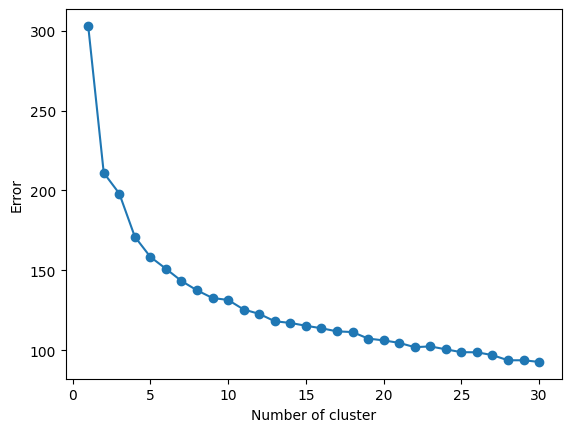

In [ ]:
# Plot the graph
plt.figure()
plt.plot(list(distance.keys()), list(distance.values()), marker = 'o')
plt.xlabel("Number of cluster")
plt.ylabel("Error")
plt.show()

The plot is not as clear on which value would be best, but shows a decline in gradient value around 10, sometimes showing a slight drop just after or before.

In [ ]:
# Final k-means clustering model 
x_scaled = preProcess(newData)
km2 = TimeSeriesKMeans(n_clusters=20, max_iter=1000)
km2.fit(x_scaled)

<ipython-input-33-7d5b2e3406be>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tempArray = np.dstack(toProcess.values())   # Convert the dictionary into a numpy 3d array


TimeSeriesKMeans(max_iter=1000, n_clusters=20)

In [ ]:
# Test the model with the same stocks we used previously, to see if the model categorises them similarly
testData = {}
testData['AAPL'] = df.loc[df['symbol'] == 'AAPL']
testData['MSFT'] = df.loc[df['symbol'] == 'MSFT']
testData['AMZN'] = df.loc[df['symbol'] == 'AMZN']
testData['GOOGL'] = df.loc[df['symbol'] == 'GOOGL']

tempData = preProcess(testData)
dataShape = tempData.shape
predictions = km2.predict(tempData)
print(predictions)

[ 3  0  0 19]


<ipython-input-33-7d5b2e3406be>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tempArray = np.dstack(toProcess.values())   # Convert the dictionary into a numpy 3d array


## Exporting JSON

*Enabling the front-end platform to use the labels for each of the stocks when required.*

In [ ]:
# Needs to be converted to a list (rather than Numpy Array) in order for it to be output as a JSON
output = {}
for row in day1.itertuples():
  tepmDictionary = {}
  tepmDictionary[row[2]] = df.loc[df['symbol'] == row[2]]
  output[row[2]] = km2.predict(preProcess(tepmDictionary)).tolist()

<ipython-input-33-7d5b2e3406be>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tempArray = np.dstack(toProcess.values())   # Convert the dictionary into a numpy 3d array
<ipython-input-33-7d5b2e3406be>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tempArray = np.dstack(toProcess.values())   # Convert the dictionary into a numpy 3d array
<ipython-input-33-7d5b2e3406be>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tempArray = np.dstack(toProcess.values())   # Convert the diction

In [ ]:
# Save the labels with their corresponding symbols as a dictionary within a JSON file  
jsonOutput = (json.dumps(output, ensure_ascii=False))

with open('stockLabels.json', 'w') as f:
  f.write(str(jsonOutput.encode('utf-8')))

files.download('stockLabels.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>